# Week 9 Practical

In this practical we will be looking at a dataset called "Symptom2Disease" 
from https://www.kaggle.com/datasets/niyarrbarman/symptom2disease 

Authors:

- Niyar R Barman
- Faizal Karim
- Krish Sharma

It's not quite real, but it is believable: their methodology was:

> We collected disease symptoms for 24 common diseases. We then used LLMs to convert the
> raw data into natural language description of symptoms.

## Data preparation

The data set is in the same folder as this jupyter notebook, with the name Symptom2Disease.csv

Load it up into a dataframe and view it

In [64]:
import pandas

df = pandas.read_csv('Symptom2Disease.csv')
df.sample(5)

Unnamed: 0                            label  \
754          154             Cervical spondylosis   
960           60                          allergy   
1047         147  gastroesophageal reflux disease   
359           59                      Common Cold   
361           61                      Common Cold   

                                                   text  
754   Back pain, a coughing cough, and numbness in m...  
960   I often sneeze and have a runny nose. My eyes ...  
1047  My throat often feels like it's on fire, espec...  
359   I've been quite exhausted and ill. I have been...  
361   I can't stop sneezing, and I'm exhausted and s...

How many different diseases are listed ("label")? Is this a balanced data set?

In [65]:
print(df.label.unique())
print(df.label.nunique())
print(df.label.value_counts())

['Psoriasis' 'Varicose Veins' 'Typhoid' 'Chicken pox' 'Impetigo' 'Dengue'
 'Fungal infection' 'Common Cold' 'Pneumonia' 'Dimorphic Hemorrhoids'
 'Arthritis' 'Acne' 'Bronchial Asthma' 'Hypertension' 'Migraine'
 'Cervical spondylosis' 'Jaundice' 'Malaria' 'urinary tract infection'
 'allergy' 'gastroesophageal reflux disease' 'drug reaction'
 'peptic ulcer disease' 'diabetes']
24
Psoriasis                          50
Varicose Veins                     50
peptic ulcer disease               50
drug reaction                      50
gastroesophageal reflux disease    50
allergy                            50
urinary tract infection            50
Malaria                            50
Jaundice                           50
Cervical spondylosis               50
Migraine                           50
Hypertension                       50
Bronchial Asthma                   50
Acne                               50
Arthritis                          50
Dimorphic Hemorrhoids              50
Pneumonia   

We'll start with a slightly easier problem: instead of predicting the disease specifically, let's
just see whether someone with those symptoms should visit a general practitioner to be treated, or whether
they will end up seeing a specialist.

The diseases that are very common and general practitioner might be able to treat are:

- Common Cold

- Bronchial Asthma

- Hypertension

- Migraine

- Allergy

- Drug Reaction

- Urinary Tract Infection

Update your dataframe with a column "requires_specialist" for the diseases not in that list.

In [69]:
dermatology_diseases = ['Psoriasis', 'Impetigo', 'Acne']
general_practitioner_diseases = ['Common Cold', 'Bronchial Asthma', 'Hypertension', 'Migraine', 'Allergy',
            'Drug Reaction',  'Urinary Tract Infection']
gastroenterology_diseases = ['Gastroesophageal Reflux Disease (GERD)', 'Peptic Ulcer Disease']
infectious_diseases = ['Typhoid', 'Chicken Pox', 'Dengue', 'Fungal Infection', 'Malaria', ]

df['requires_specialist'] = ~df.label.isin(general_practitioner_diseases)

Is it a balanced data set now?

In [70]:
df.requires_specialist.value_counts()

True     1000
False     200
Name: requires_specialist, dtype: int64

Split the data into training, validation and test data. You can do this by running 
`sklearn.model_selection.train_test_split` twice.

In [71]:
import sklearn.model_selection

pseudo_train, test_data = sklearn.model_selection.train_test_split(df, random_state=12345)
train_data, validation_data = sklearn.model_selection.train_test_split(pseudo_train, random_state=1235)

Create a `keras.layers.TextVectorization` object with `output_mode='tf_idf'`, and `.adapt()` it to 
the text of your training data.

In [137]:
import keras

# In a later exercise students come back here to set max_tokens
vectorizer = keras.layers.TextVectorization(output_mode='tf_idf',# max_tokens=715, 
                                            ngrams=2)
vectorizer.adapt(train_data.text)

2023-04-30 18:24:15.500199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Convert your training, validation and test data into TF-IDF vectors using your vectorizer.

In [138]:
train_vectors = vectorizer(train_data.text)
validation_vectors = vectorizer(validation_data.text)
test_vectors = vectorizer(test_data.text)

## A small logistic regression classifier using Keras

Let's see if we can predict who is going to need a specialist.

`prog3f.py` is a good sample to work from.

Create a `keras.Input` object. Its shape should be the size of the vocabulary in your vectorizer.

In [139]:
inputs = keras.Input(shape=(vectorizer.vocabulary_size()))

Create a `keras.layers.Dense` object to be your output layer, and pass it your input object
as a function argument.

Because there is only one value ("needs a specialist or not"), it should have one neuron, and a sigmoid activation.

In [140]:
output = keras.layers.Dense(1, activation='sigmoid')(inputs)

Create a `keras.Model` object. `inputs=` the input object; `outputs=` the output layer

In [141]:
model = keras.Model(inputs=inputs, outputs=output)

Compile the model. There are only two classes, so you can use `binary_crossentropy`.

We want to know accuracy, recall and precision. (Given how unbalanced the data set is, it would
be nice to have F1Score calculated for us. That would require a bit more code that we would
have time to write in this practical.)

_Note to cohorts after 2023-10: check to see if F1Score is now part of default Keras releases._

In [142]:
model.compile(loss='binary_crossentropy', metrics=["accuracy", 
                                                   keras.metrics.Precision(),
             keras.metrics.Recall()])

Display a summary of your model.

In [143]:
model.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 7783)]            0         
                                                                 
 dense_19 (Dense)            (None, 1)                 7784      
                                                                 
Total params: 7,784
Trainable params: 7,784
Non-trainable params: 0
_________________________________________________________________


Fit the model. 

You will need:

- `x` will be your training vectors

- `y` will be the `requires_specialist` column

- `validation_data` will be the same as for training, but using the validation data

- You might want a callback to stop training when the validation loss stops improving.

- You won't need many epochs: it should be less than 100, and they should be quick to run.

Save the history into a variable so that we can look at it.

In [144]:
history = model.fit(x=train_vectors, y=train_data.requires_specialist,
          validation_data=(validation_vectors, 
                          validation_data.requires_specialist),
          callbacks=[keras.callbacks.EarlyStopping(
              monitor='val_loss',
              patience=3
          )],
          epochs=500
         )

Epoch 1/500


2023-04-30 18:24:20.367009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - ETA: 0s - loss: 0.4344 - accuracy: 0.8370 - precision_7: 0.8765 - recall_7: 0.9333

2023-04-30 18:24:21.085643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 1s 36ms/step - loss: 0.4344 - accuracy: 0.8370 - precision_7: 0.8765 - recall_7: 0.9333 - val_loss: 0.3600 - val_accuracy: 0.9022 - val_precision_7: 0.9031 - val_recall_7: 0.9833
Epoch 2/500
22/22 [==============================] - 0s 13ms/step - loss: 0.2075 - accuracy: 0.9481 - precision_7: 0.9422 - recall_7: 0.9982 - val_loss: 0.2459 - val_accuracy: 0.9511 - val_precision_7: 0.9424 - val_recall_7: 1.0000
Epoch 3/500
22/22 [==============================] - 0s 11ms/step - loss: 0.1199 - accuracy: 0.9881 - precision_7: 0.9858 - recall_7: 1.0000 - val_loss: 0.1765 - val_accuracy: 0.9689 - val_precision_7: 0.9626 - val_recall_7: 1.0000
Epoch 4/500
22/22 [==============================] - 0s 11ms/step - loss: 0.0721 - accuracy: 0.9970 - precision_7: 0.9964 - recall_7: 1.0000 - val_loss: 0.1327 - val_accuracy: 0.9822 - val_precision_7: 0.9783 - val_recall_7: 1.0000
Epoch 5/500
22/22 [==============================] - 0s 10ms/step - loss: 0.0444 - a

Make a matplotlib chart showing the accuracy and training loss over time.

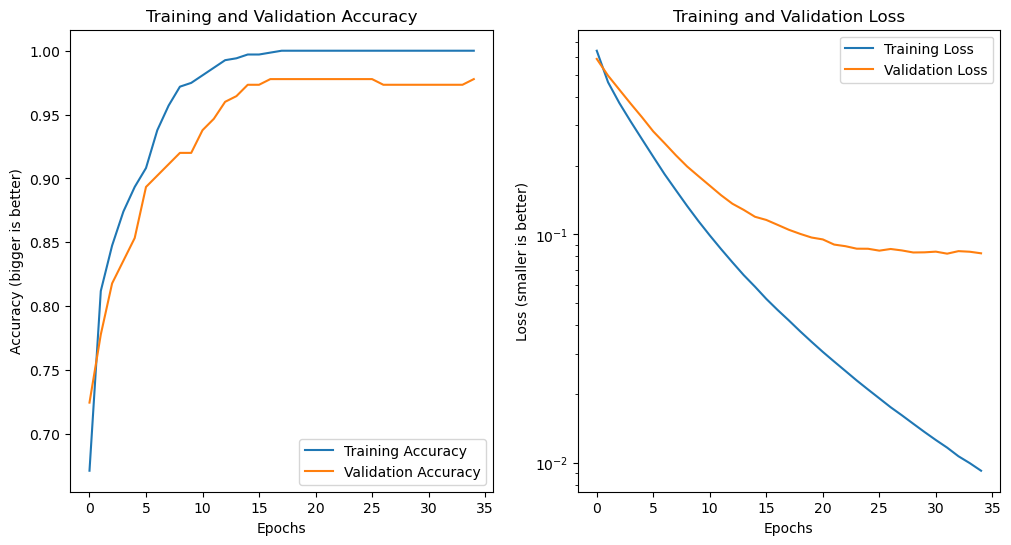

In [128]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
axes[0].plot(history.history['accuracy'],
        label='Training Accuracy')
axes[0].plot(history.history['val_accuracy'],
        label='Validation Accuracy')
axes[0].set_title('Training and Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy (bigger is better)')
axes[0].legend()


axes[1].plot(history.history['loss'],
        label='Training Loss')
axes[1].plot(history.history['val_loss'],
        label='Validation Loss')
axes[1].set_title('Training and Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss (smaller is better)')
axes[1].legend()
axes[1].set_yscale('log')

Calculate the corpus size, the vocabulary size and their ratio (i.e. the corpus size divided by the vocabulary size).
Based on this and the previous charts, decide whether the model is likely to be overfitting.

In [116]:
print("Corpus size = ", train_data.shape[0])
print("Vocabulary size =", vectorizer.vocabulary_size())
print("Corpus : vocabulary ratio =",
      train_data.shape[0] / vectorizer.vocabulary_size())

Corpus size =  675
Vocabulary size = 100
Corpus : vocabulary ratio = 6.75


Calculate an appropriate vocabulary size if you only wanted to include words that appeared in the
training data at least 3 times. Go back to where you defined your TextVectorization object and 
set `max_tokens` to (this value + 1). It might give you a tiny improvement in your validation scores.

Also try using bigrams. Does this help? 

In [119]:
import nltk
import collections
c = collections.Counter()
for sentence in train_data.text:
    for word in nltk.word_tokenize(sentence):
        c[word.upper()] += 1
vocab_size = sum([1 for x in c.values() if x > 2])
print(vocab_size)

714


Use `.evaluate` on your test data to confirm that your validation results are still close to the test results and
our parameter tuning for validation hasn't altered the results too much.

In [145]:
print("Test evaluation:")
print(model.evaluate(test_vectors,
                     test_data.requires_specialist,
                     return_dict=True,
                     verbose=0))

Test evaluation:
{'loss': 0.012606282718479633, 'accuracy': 0.996666669845581, 'precision_7': 0.9962406158447266, 'recall_7': 1.0}


## Explainability

People's health is important. We can't let them use a black-box classifier for analysing their health conditions.

What words were the most predictive that a general practitioner could help, and what words were most predictive
that a specialist would be required?

The `wordeffects.py` file might be helpful here.

In [147]:
vocab = vectorizer.get_vocabulary()
weights = model.get_weights()[0][:,0]
strengths = pandas.Series(index=vocab, data=weights)

print(strengths.nlargest(5))
print(strengths.nsmallest(5))

my skin     0.270518
back        0.260835
skin has    0.245924
vomiting    0.240916
rash        0.238767
dtype: float32
headache chest     -0.214452
my fever           -0.211203
fever is           -0.193619
mucoid             -0.192925
irritability and   -0.186681
dtype: float32


## Harder task: predicting the actual disease, not just who to go to

Unlike (say) the sklearn classifiers, keras can't work with text labels for classes. Use
`sklearn.preprocessing.LabelEncoder` to convert the disease labels into integer labels.

In [148]:
import sklearn.preprocessing
encoder = sklearn.preprocessing.LabelEncoder()
df['integer_labels'] = encoder.fit_transform(df['label'])
df.sample(5)

Unnamed: 0                            label  \
1018         118  gastroesophageal reflux disease   
415          115                        Pneumonia   
246          246                         Impetigo   
470          170            Dimorphic Hemorrhoids   
995           95                          allergy   

                                                   text  integer_labels  \
1018  I feel as though acid or food is backing up in...              21   
415   I've been feeling really sick with a high feve...              14   
246   Over the last week, the rash on my face has go...              10   
470   Since I've been constipated, using the restroo...               7   
995   I frequently have exhaustion, a terrible taste...              18   

      requires_specialist  
1018                 True  
415                  True  
246                  True  
470                  True  
995                  True

You can re-use the existing `keras.Input` since that hasn't changed, or define a new one.
Then create an output layer:

- It will need as many neurons as there are diseases

- Use a 'softmax' activation to normalise the probabilities

And then create a model using those inputs and outputs.

In [149]:
inputs = keras.Input(shape=(vectorizer.vocabulary_size()))
output = keras.layers.Dense(df.label.nunique(), activation='softmax')(inputs)
model = keras.Model(inputs=inputs, outputs=output)

To compile this model we will need to use `sparse_categorical_crossentropy` as the
loss. Let's use accuracy as the only other metric (we know how to add more if we need to.)

In [150]:
model.compile(loss='sparse_categorical_crossentropy', metrics=["accuracy"])
history = model.fit(x=train_vectors, y=train_data.integer_labels,
          validation_data=(validation_vectors, 
                          validation_data.integer_labels),
          callbacks=[keras.callbacks.EarlyStopping(
              monitor='val_loss',
              patience=30
          )],
          epochs=500
         )

Epoch 1/500
 6/22 [=======>......................] - ETA: 0s - loss: 2.9972 - accuracy: 0.2083    

2023-04-30 18:30:54.418454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 1s 16ms/step - loss: 2.3675 - accuracy: 0.4844 - val_loss: 1.7414 - val_accuracy: 0.6311
Epoch 2/500
11/22 [==============>...............] - ETA: 0s - loss: 0.9650 - accuracy: 0.9631

2023-04-30 18:30:54.789708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 0s 8ms/step - loss: 0.8231 - accuracy: 0.9704 - val_loss: 1.1186 - val_accuracy: 0.7511
Epoch 3/500
22/22 [==============================] - 0s 7ms/step - loss: 0.3192 - accuracy: 1.0000 - val_loss: 0.8167 - val_accuracy: 0.8222
Epoch 4/500
22/22 [==============================] - 0s 8ms/step - loss: 0.1328 - accuracy: 1.0000 - val_loss: 0.6337 - val_accuracy: 0.8489
Epoch 5/500
22/22 [==============================] - 0s 8ms/step - loss: 0.0590 - accuracy: 1.0000 - val_loss: 0.5150 - val_accuracy: 0.9022
Epoch 6/500
22/22 [==============================] - 0s 8ms/step - loss: 0.0276 - accuracy: 1.0000 - val_loss: 0.4261 - val_accuracy: 0.9067
Epoch 7/500
22/22 [==============================] - 0s 7ms/step - loss: 0.0133 - accuracy: 1.0000 - val_loss: 0.3621 - val_accuracy: 0.9111
Epoch 8/500
22/22 [==============================] - 0s 7ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.3128 - val_accuracy: 0.9200
Epoch 9/500
22/22 [======

Plot the accuracy and loss for the training data and validation data

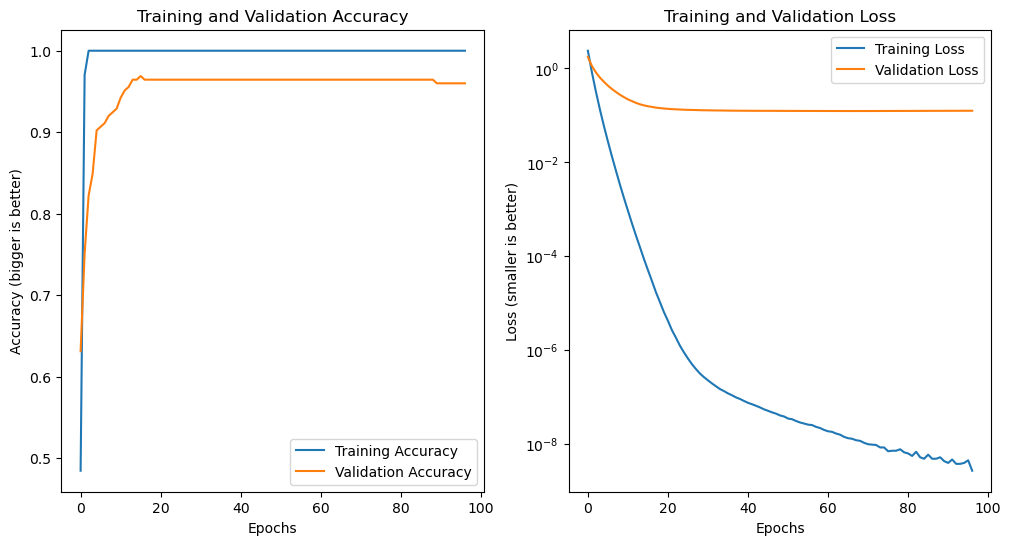

In [151]:
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
axes[0].plot(history.history['accuracy'],
        label='Training Accuracy')
axes[0].plot(history.history['val_accuracy'],
        label='Validation Accuracy')
axes[0].set_title('Training and Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy (bigger is better)')
axes[0].legend()


axes[1].plot(history.history['loss'],
        label='Training Loss')
axes[1].plot(history.history['val_loss'],
        label='Validation Loss')
axes[1].set_title('Training and Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss (smaller is better)')
axes[1].legend()
axes[1].set_yscale('log')

It's less obvious how to improve this model now, but we do have fairly good accuracy anyway. 

Confirm that the accuracy is also quite good on the test data.

In [153]:
print("Test evaluation:")
print(model.evaluate(test_vectors,
                     test_data.integer_labels,
                     return_dict=True,
                     verbose=0))

Test evaluation:
{'loss': 0.15758579969406128, 'accuracy': 0.9466666579246521}


## Free-form

Try to optimise the model by adding extra layers, modifying the vocabulary or any other ideas you want to try out.

In [157]:
# Adding a few extra layers and some n-grams would help if we were underfitting...
think_vectorizer = keras.layers.TextVectorization(output_mode='tf_idf', ngrams=2, max_tokens=vocab_size)
think_vectorizer.adapt(train_data.text)
think_inputs = keras.Input(shape=(think_vectorizer.vocabulary_size(),))
train_vectors = think_vectorizer(train_data.text)
validation_vectors = think_vectorizer(validation_data.text)
test_vectors = think_vectorizer(test_data.text)
think_layer = keras.layers.Dense(96, activation='softmax')(think_inputs)
dropsies  = keras.layers.Dropout(0.3)(think_layer)
second_thinking_layer = keras.layers.Dense(48, activation='softmax')(dropsies)
think_output = keras.layers.Dense(df.label.nunique(), activation='softmax')(second_thinking_layer)
model = keras.Model(inputs=think_inputs, outputs=think_output)
model.compile(loss='sparse_categorical_crossentropy', metrics=["accuracy"])
history = model.fit(x=train_vectors, y=train_data.integer_labels,
          validation_data=(validation_vectors, 
                          validation_data.integer_labels),
          epochs=500
         )

2023-04-30 19:07:34.564322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/500


2023-04-30 19:07:35.338124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 1s 27ms/step - loss: 3.1790 - accuracy: 0.0341 - val_loss: 3.1781 - val_accuracy: 0.0400
Epoch 2/500
 1/22 [>.............................] - ETA: 0s - loss: 3.1796 - accuracy: 0.0000e+00

2023-04-30 19:07:36.122171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 0s 13ms/step - loss: 3.1766 - accuracy: 0.0593 - val_loss: 3.1771 - val_accuracy: 0.0756
Epoch 3/500
22/22 [==============================] - 0s 10ms/step - loss: 3.1745 - accuracy: 0.0667 - val_loss: 3.1763 - val_accuracy: 0.0267
Epoch 4/500
22/22 [==============================] - 0s 9ms/step - loss: 3.1728 - accuracy: 0.0578 - val_loss: 3.1754 - val_accuracy: 0.0267
Epoch 5/500
22/22 [==============================] - 0s 9ms/step - loss: 3.1711 - accuracy: 0.0504 - val_loss: 3.1746 - val_accuracy: 0.0267
Epoch 6/500
22/22 [==============================] - 0s 8ms/step - loss: 3.1687 - accuracy: 0.0504 - val_loss: 3.1737 - val_accuracy: 0.0267
Epoch 7/500
22/22 [==============================] - 0s 9ms/step - loss: 3.1671 - accuracy: 0.0504 - val_loss: 3.1724 - val_accuracy: 0.0267
Epoch 8/500
22/22 [==============================] - 0s 8ms/step - loss: 3.1646 - accuracy: 0.0504 - val_loss: 3.1711 - val_accuracy: 0.0267
Epoch 9/500
22/22 [====

Epoch 60/500
22/22 [==============================] - 0s 8ms/step - loss: 2.7168 - accuracy: 0.5170 - val_loss: 2.7679 - val_accuracy: 0.5422
Epoch 61/500
22/22 [==============================] - 0s 8ms/step - loss: 2.7242 - accuracy: 0.4919 - val_loss: 2.7562 - val_accuracy: 0.5422
Epoch 62/500
22/22 [==============================] - 0s 8ms/step - loss: 2.7311 - accuracy: 0.4859 - val_loss: 2.7416 - val_accuracy: 0.5422
Epoch 63/500
22/22 [==============================] - 0s 8ms/step - loss: 2.6868 - accuracy: 0.5156 - val_loss: 2.7267 - val_accuracy: 0.5378
Epoch 64/500
22/22 [==============================] - 0s 8ms/step - loss: 2.6728 - accuracy: 0.5037 - val_loss: 2.7107 - val_accuracy: 0.5333
Epoch 65/500
22/22 [==============================] - 0s 8ms/step - loss: 2.6580 - accuracy: 0.5111 - val_loss: 2.6962 - val_accuracy: 0.5378
Epoch 66/500
22/22 [==============================] - 0s 8ms/step - loss: 2.6542 - accuracy: 0.5022 - val_loss: 2.6805 - val_accuracy: 0.5378
Epoch 

22/22 [==============================] - 0s 10ms/step - loss: 1.5017 - accuracy: 0.5230 - val_loss: 1.3239 - val_accuracy: 0.5778
Epoch 175/500
22/22 [==============================] - 0s 11ms/step - loss: 1.5580 - accuracy: 0.4800 - val_loss: 1.3232 - val_accuracy: 0.5778
Epoch 176/500
22/22 [==============================] - 0s 10ms/step - loss: 1.5766 - accuracy: 0.5037 - val_loss: 1.3087 - val_accuracy: 0.5778
Epoch 177/500
22/22 [==============================] - 0s 10ms/step - loss: 1.4822 - accuracy: 0.5126 - val_loss: 1.3150 - val_accuracy: 0.5822
Epoch 178/500
22/22 [==============================] - 0s 9ms/step - loss: 1.5715 - accuracy: 0.4933 - val_loss: 1.2985 - val_accuracy: 0.6044
Epoch 179/500
22/22 [==============================] - 0s 9ms/step - loss: 1.5239 - accuracy: 0.5081 - val_loss: 1.2945 - val_accuracy: 0.6044
Epoch 180/500
22/22 [==============================] - 0s 9ms/step - loss: 1.5666 - accuracy: 0.4830 - val_loss: 1.2909 - val_accuracy: 0.5778
Epoch 181

22/22 [==============================] - 0s 8ms/step - loss: 1.2559 - accuracy: 0.5067 - val_loss: 1.2752 - val_accuracy: 0.5600
Epoch 289/500
22/22 [==============================] - 0s 8ms/step - loss: 1.3240 - accuracy: 0.5126 - val_loss: 1.3135 - val_accuracy: 0.5511
Epoch 290/500
22/22 [==============================] - 0s 8ms/step - loss: 1.2521 - accuracy: 0.5096 - val_loss: 1.2680 - val_accuracy: 0.5511
Epoch 291/500
22/22 [==============================] - 0s 8ms/step - loss: 1.3123 - accuracy: 0.5081 - val_loss: 1.2961 - val_accuracy: 0.5511
Epoch 292/500
22/22 [==============================] - 0s 8ms/step - loss: 1.2600 - accuracy: 0.5081 - val_loss: 1.3000 - val_accuracy: 0.5511
Epoch 293/500
22/22 [==============================] - 0s 8ms/step - loss: 1.2656 - accuracy: 0.4993 - val_loss: 1.2823 - val_accuracy: 0.5556
Epoch 294/500
22/22 [==============================] - 0s 8ms/step - loss: 1.2842 - accuracy: 0.5156 - val_loss: 1.2797 - val_accuracy: 0.5556
Epoch 295/500

22/22 [==============================] - 0s 8ms/step - loss: 1.2443 - accuracy: 0.5496 - val_loss: 1.4311 - val_accuracy: 0.5644
Epoch 403/500
22/22 [==============================] - 0s 8ms/step - loss: 1.2278 - accuracy: 0.5600 - val_loss: 1.4193 - val_accuracy: 0.5600
Epoch 404/500
22/22 [==============================] - 0s 8ms/step - loss: 1.1743 - accuracy: 0.5748 - val_loss: 1.3976 - val_accuracy: 0.5556
Epoch 405/500
22/22 [==============================] - 0s 8ms/step - loss: 1.1829 - accuracy: 0.5807 - val_loss: 1.3990 - val_accuracy: 0.5733
Epoch 406/500
22/22 [==============================] - 0s 8ms/step - loss: 1.2522 - accuracy: 0.5481 - val_loss: 1.4009 - val_accuracy: 0.5600
Epoch 407/500
22/22 [==============================] - 0s 8ms/step - loss: 1.2502 - accuracy: 0.5511 - val_loss: 1.4104 - val_accuracy: 0.5689
Epoch 408/500
22/22 [==============================] - 0s 8ms/step - loss: 1.1923 - accuracy: 0.5719 - val_loss: 1.4126 - val_accuracy: 0.5733
Epoch 409/500

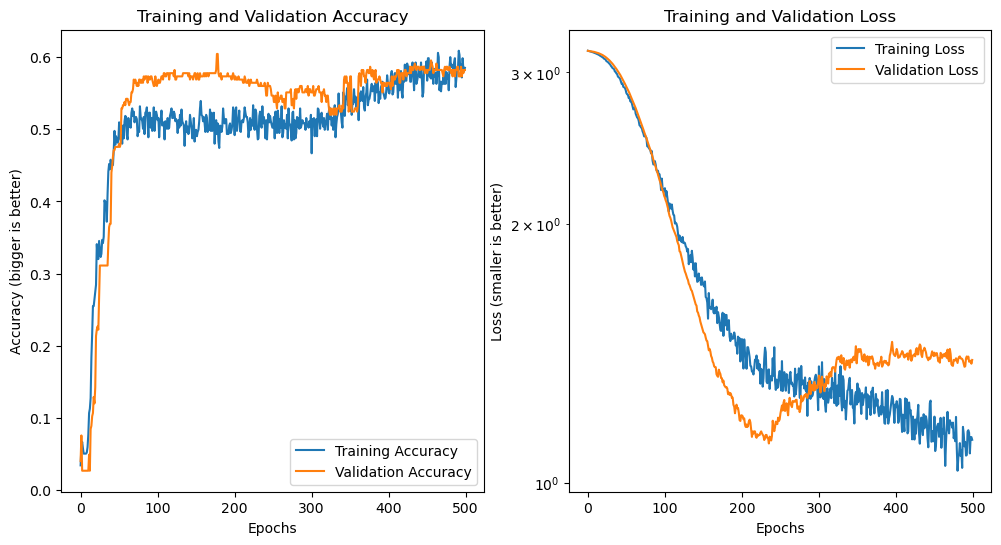

In [158]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
axes[0].plot(history.history['accuracy'],
        label='Training Accuracy')
axes[0].plot(history.history['val_accuracy'],
        label='Validation Accuracy')
axes[0].set_title('Training and Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy (bigger is better)')
axes[0].legend()


axes[1].plot(history.history['loss'],
        label='Training Loss')
axes[1].plot(history.history['val_loss'],
        label='Validation Loss')
axes[1].set_title('Training and Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss (smaller is better)')
axes[1].legend()
axes[1].set_yscale('log')

In [156]:
print(model.evaluate(test_vectors,
                     test_data.integer_labels,
                     return_dict=True,
                     verbose=0))

{'loss': 7.0512776374816895, 'accuracy': 0.30000001192092896}
